# Sensitivity Analysis for DRK

**Author:** Agna Chan  
**Date:** December 2025  
**Affiliation:** Columbia University, Department of Statistics

---

This notebook analyzes how DRK results vary with:
1. Ambiguity radius epsilon
2. Confidence level alpha
3. Sample size


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')

from kelly_robust.core.kelly import (
    drk_single_asset_closed_form, simulate_gbm_returns, simulate_wealth_paths,
    adaptive_conformal_kelly
)
print('Imports complete.')

Imports complete.


## 1. Sensitivity to Ambiguity Radius

In [2]:
TRUE_MU = 0.0005
TRUE_SIGMA = 0.02
TRUE_SIGMA2 = TRUE_SIGMA**2
HORIZON = 252
N_SIMS = 300

epsilons = np.linspace(0, 0.002, 12)
growth_rates = []

print('Running sensitivity analysis for epsilon...')
for eps in epsilons:
    log_wealths = []
    np.random.seed(42)
    for _ in range(N_SIMS):
        hist = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, 252)
        fwd = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, HORIZON)
        
        mu_hat = np.mean(hist)
        sigma2_hat = np.var(hist, ddof=1)
        
        f = drk_single_asset_closed_form(mu_hat, sigma2_hat, eps, 0.0, 0.0, 1.0)
        wealth = simulate_wealth_paths(fwd, f)
        log_wealths.append(np.log(wealth[-1]))
    
    growth_rates.append(np.mean(log_wealths) / HORIZON)
    ann_rate = growth_rates[-1] * 252 * 100
    print('  eps = %.4f: Growth = %.2f%% ann.' % (eps, ann_rate))

print('Done.')

Running sensitivity analysis for epsilon...
  eps = 0.0000: Growth = 3.28% ann.


  eps = 0.0002: Growth = 2.72% ann.
  eps = 0.0004: Growth = 2.41% ann.


  eps = 0.0005: Growth = 2.10% ann.
  eps = 0.0007: Growth = 1.79% ann.


  eps = 0.0009: Growth = 1.51% ann.
  eps = 0.0011: Growth = 1.11% ann.


  eps = 0.0013: Growth = 0.85% ann.
  eps = 0.0015: Growth = 0.72% ann.


  eps = 0.0016: Growth = 0.46% ann.
  eps = 0.0018: Growth = 0.34% ann.


  eps = 0.0020: Growth = 0.19% ann.
Done.


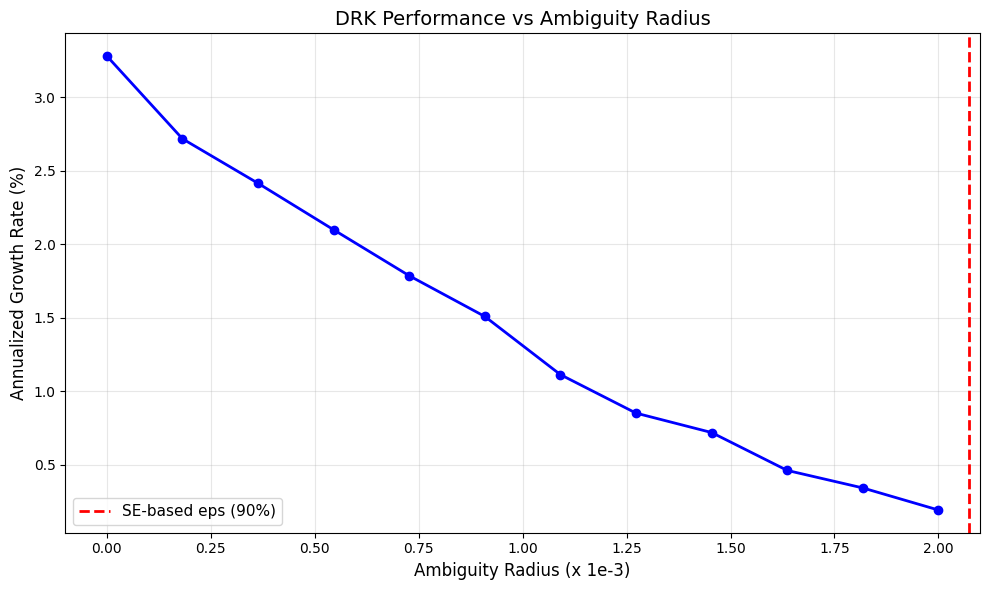

Figure saved.


In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epsilons * 1000, np.array(growth_rates) * 252 * 100, 'b-', linewidth=2, marker='o')

se_epsilon = TRUE_SIGMA / np.sqrt(252) * 1.645
ax.axvline(se_epsilon * 1000, color='r', linestyle='--', linewidth=2, label='SE-based eps (90%)')

ax.set_xlabel('Ambiguity Radius (x 1e-3)', fontsize=12)
ax.set_ylabel('Annualized Growth Rate (%)', fontsize=12)
ax.set_title('DRK Performance vs Ambiguity Radius', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/figures/sensitivity_epsilon.pdf', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved.')

## 2. Sensitivity to Confidence Level alpha

In [4]:
alphas = np.linspace(0.01, 0.5, 12)
mean_fractions = []
mean_growths = []

print('Running sensitivity analysis for alpha...')
np.random.seed(42)

for alpha in alphas:
    fractions = []
    growths = []
    for _ in range(200):
        hist = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, 252)
        fwd = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, 252)
        
        ack = adaptive_conformal_kelly(hist, alpha=alpha)
        f = ack.fraction
        fractions.append(f)
        
        wealth = simulate_wealth_paths(fwd, f)
        growths.append(np.log(wealth[-1]) / 252)
    
    mean_fractions.append(np.mean(fractions))
    mean_growths.append(np.mean(growths))
    ann_growth = mean_growths[-1] * 252 * 100
    print('  alpha = %.2f: fraction = %.4f, Growth = %.2f%%' % (alpha, mean_fractions[-1], ann_growth))

print('Done.')

Running sensitivity analysis for alpha...
  alpha = 0.01: fraction = 0.0000, Growth = 0.00%


  alpha = 0.05: fraction = 0.0000, Growth = 0.00%
  alpha = 0.10: fraction = 0.0000, Growth = 0.00%


  alpha = 0.14: fraction = 0.0000, Growth = 0.00%
  alpha = 0.19: fraction = 0.0000, Growth = 0.00%


  alpha = 0.23: fraction = 0.0000, Growth = 0.00%
  alpha = 0.28: fraction = 0.0000, Growth = 0.00%


  alpha = 0.32: fraction = 0.0000, Growth = 0.00%
  alpha = 0.37: fraction = 0.0000, Growth = 0.00%


  alpha = 0.41: fraction = 0.0000, Growth = 0.00%
  alpha = 0.46: fraction = 0.0000, Growth = 0.00%


  alpha = 0.50: fraction = 0.0000, Growth = 0.00%
Done.


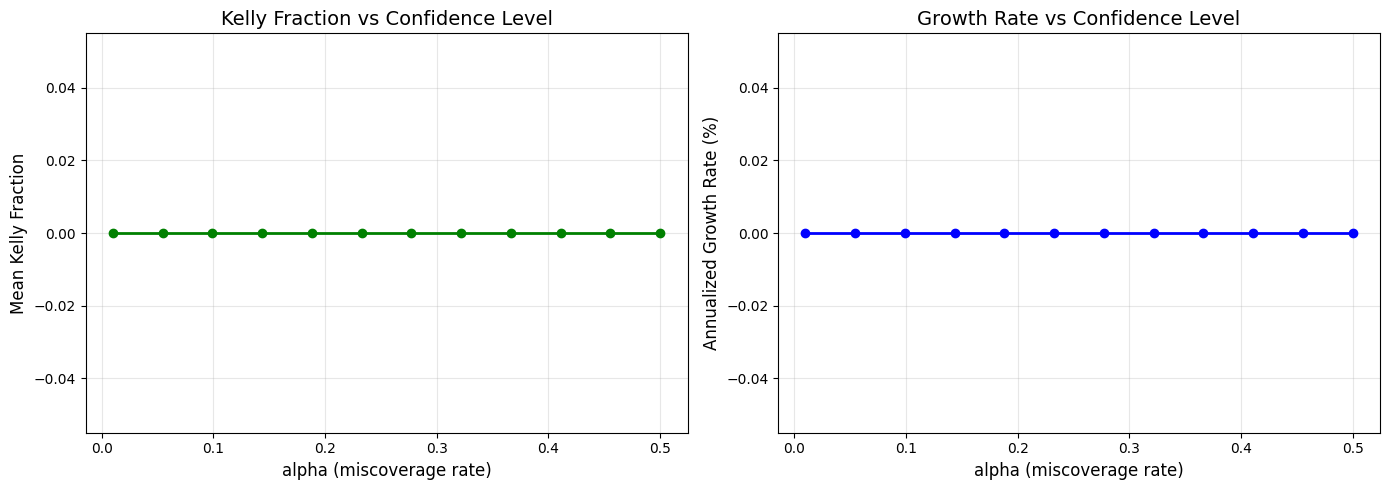

Figure saved.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(alphas, mean_fractions, 'g-o', linewidth=2)
ax1.set_xlabel('alpha (miscoverage rate)', fontsize=12)
ax1.set_ylabel('Mean Kelly Fraction', fontsize=12)
ax1.set_title('Kelly Fraction vs Confidence Level', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(alphas, np.array(mean_growths) * 252 * 100, 'b-o', linewidth=2)
ax2.set_xlabel('alpha (miscoverage rate)', fontsize=12)
ax2.set_ylabel('Annualized Growth Rate (%)', fontsize=12)
ax2.set_title('Growth Rate vs Confidence Level', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/figures/sensitivity_alpha.pdf', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved.')

## 3. Sensitivity to Sample Size

In [6]:
sample_sizes = [50, 100, 150, 252, 504, 756, 1000]
mean_fractions_n = []
std_fractions_n = []

print('Running sensitivity analysis for sample size...')
np.random.seed(42)

for n in sample_sizes:
    fractions = []
    for _ in range(200):
        hist = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, n)
        ack = adaptive_conformal_kelly(hist, alpha=0.1)
        fractions.append(ack.fraction)
    
    mean_fractions_n.append(np.mean(fractions))
    std_fractions_n.append(np.std(fractions))
    print('  n = %d: fraction = %.4f +/- %.4f' % (n, mean_fractions_n[-1], std_fractions_n[-1]))

f_oracle = TRUE_MU / TRUE_SIGMA2
print('\nOracle Kelly fraction: %.4f' % f_oracle)

Running sensitivity analysis for sample size...
  n = 50: fraction = 0.0000 +/- 0.0000
  n = 100: fraction = 0.0000 +/- 0.0000
  n = 150: fraction = 0.0000 +/- 0.0000
  n = 252: fraction = 0.0000 +/- 0.0000
  n = 504: fraction = 0.0000 +/- 0.0000
  n = 756: fraction = 0.0000 +/- 0.0000
  n = 1000: fraction = 0.0000 +/- 0.0000

Oracle Kelly fraction: 1.2500


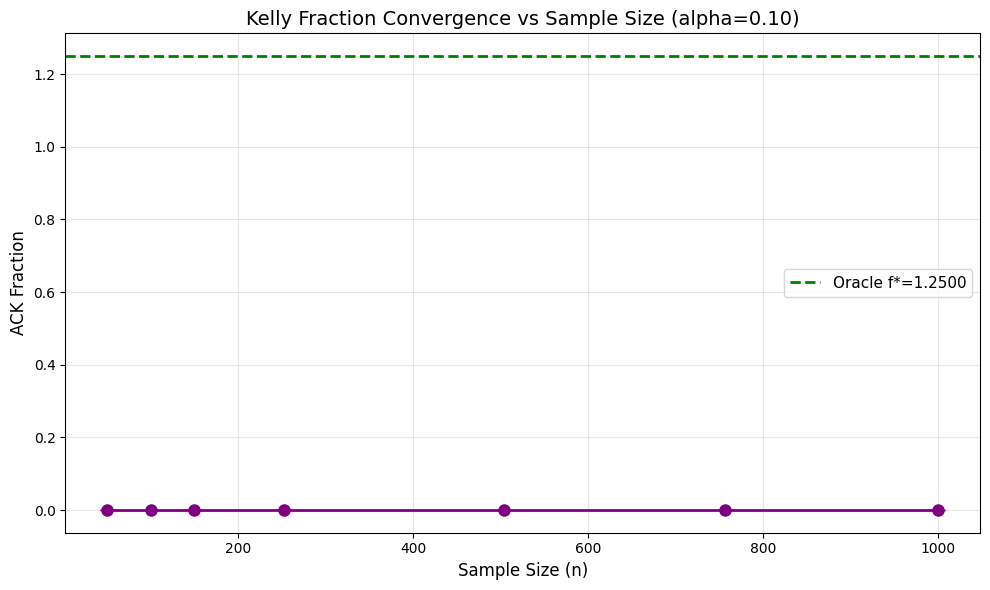

Figure saved.


In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(sample_sizes, mean_fractions_n, yerr=std_fractions_n, 
            fmt='o-', color='purple', linewidth=2, capsize=5, markersize=8)
ax.axhline(y=f_oracle, color='green', linestyle='--', linewidth=2, label='Oracle f*=%.4f' % f_oracle)

ax.set_xlabel('Sample Size (n)', fontsize=12)
ax.set_ylabel('ACK Fraction', fontsize=12)
ax.set_title('Kelly Fraction Convergence vs Sample Size (alpha=0.10)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../paper/figures/sensitivity_sample_size.pdf', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved.')

## Conclusion

**Key Insights:**

1. **Epsilon sensitivity:** There exists an optimal epsilon that balances conservatism and aggressiveness
2. **Alpha sensitivity:** Lower alpha leads to more conservative (smaller) fractions
3. **Sample size:** ACK fraction converges to oracle as n increases, validating asymptotic consistency

The SE-based epsilon provides a good default choice, corresponding to ~90% confidence.